# About This Notebook

This notebook takes in data from https://www.reddit.com/r/Homebrewing/  via the Push Shift API found at www.pushshift.io

This notebook consists of five steps of initial data retrieval and preprocessing for a Natural Language Processing Project. 

The project at large will intake data from two different subreddits (from www.Reddit.com), clean and process the data, explore the data for relationships, create and manipulate features and then model to produce a predictive classification model. 

This notebook will begin the process described above through the following steps: 

Step 1: Data Retrieval - Is the process of pulling the data from Reddit using the Pushshift API.

* Here code was written that identifies the url to call the respective subreddit.
* It sets parameters for the Pushshift API
* Loops through to create a new request using updated parameters so that each time new information is being pulled from the subreddit.
* Creates a dataframe to store each information pull. 
* Concatenates the dataframe. 


Step 2: Initial Analysis for Cleaning - Which will analyze unique values, indexes and summary info. 



Step 3: Cleaning - Will reduce the amount of features being processed, handle duplicate values, and eliminate null values. 

Step 4: Preliminary EDA - Will conduct an initial exploration of the data to analyze unique values in greater detail, initially explore the possibility of outliers in the data and look into features that may be interesting overall but that may not make it into the advanced EDA and modeling process. 

Step 5: Preparing DF for Text Analysis - This process will reduce feature columns to just those that will be used in advanced EDA and modeling. It will then save this file to CSV for the purpose of importing into another notebook focused on advanced EDA and feature creation. 

About r/Homebrewing subreddit:

* Created in June of 2008 it is a community of brewers, mazers, vitners and cider makers. 
* There are at time of this project over 1 million members. 
* You can find more information about this community on thier Reddit Wiki https://www.reddit.com/r/Homebrewing/comments/ix1yd0/wiki_updates_new_wiki_editor/ where you will find introductions to the moderators and dedicated content creators, links to helpful Homebrewing information as well as links to their Slack and IRC channels. 
* One reason I chose this blog is because of their rule #3, 'Image only posts are not allowed.'

### Importing Libraries

In [1]:
import time
import requests
import pandas as pd
import numpy as np
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Step 1 
# Data Retrieval 
### Pulling in Data Using Pushshift API

* Code below was slightly adapted from the Pushshift mini lesson administered by Hovanes. 

In [2]:
# defining url for pushshift apo
url = 'https://api.pushshift.io/reddit/submission/search'
# creating an empty list to collect the dataframe lists
dfs = []

# number of loops that will be made. Each loop pulls a new set of posts.
loops = 30

params = {
        'subreddit': 'homebrewing', 
        'size': 100,
#         'before' :
        }


#defining the time in which I start the loop.
start_time = time.time()

#create for loop that sets the current time for the sake of ensuring we are not scraping too fast or taking too many of the sites reasoureces. 
# This for loop also pulls from requests, formats data into json and creates a dataframe
for i in range(loops):
    
    current_time = time.time()
    #requesting data
    res = requests.get(url, params) #getting request
    print(f'res {i+1} code: ', res.status_code) #printing request status to ensure it went through securely
    
    data = res.json() #using json to read
    posts = data['data'] #indexing into 'data' from json dictionary and list of dictionaries
    posts_df = pd.DataFrame(posts)
    dfs.append(posts_df) #create dataframe from 'data' dictionary
        
        
    # get oldest post time and use as before parameter in next request
    params['before'] = posts_df['created_utc'].min()#adding 'before' parameter to params dictionary
        
    #created lower limit of 1 second to ensure we are abiding by resource conventions.
    time.sleep(3)

# creating a dataframe by concatetinating all of the df lists created by the loop    
reddit_posts = pd.concat(dfs)

res 1 code:  200
res 2 code:  200
res 3 code:  200
res 4 code:  200
res 5 code:  200
res 6 code:  200
res 7 code:  200
res 8 code:  200
res 9 code:  200
res 10 code:  200
res 11 code:  200
res 12 code:  200
res 13 code:  200
res 14 code:  200
res 15 code:  200
res 16 code:  200
res 17 code:  200
res 18 code:  200
res 19 code:  200
res 20 code:  200
res 21 code:  200
res 22 code:  200
res 23 code:  200
res 24 code:  200
res 25 code:  200
res 26 code:  200
res 27 code:  200
res 28 code:  200
res 29 code:  200
res 30 code:  200


___________________
# Step 2 
# Initial Analysis for Cleaning

###  Initial Analysis of Unique Values (Prior to Cleaning)

In [4]:
reddit_posts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 99
Data columns (total 79 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   all_awardings                  3000 non-null   object 
 1   allow_live_comments            3000 non-null   bool   
 2   author                         3000 non-null   object 
 3   author_flair_css_class         207 non-null    object 
 4   author_flair_richtext          2977 non-null   object 
 5   author_flair_text              156 non-null    object 
 6   author_flair_type              2977 non-null   object 
 7   author_fullname                2977 non-null   object 
 8   author_patreon_flair           2977 non-null   object 
 9   author_premium                 2977 non-null   object 
 10  awarders                       3000 non-null   object 
 11  can_mod_post                   3000 non-null   bool   
 12  contest_mode                   3000 non-null   boo

In [5]:
reddit_posts.shape

(3000, 79)

#### 3000 unique id's

In [6]:
unique_ids = reddit_posts['id'].nunique()
unique_ids

3000

#### 1893 unique authors

In [7]:
reddit_posts['author'].nunique()

1938

#### 2378 unique posts

In [8]:
unique_posts = reddit_posts['selftext'].nunique()
unique_posts

2380



#### Percentage of Unique Posts to Unique IDs

In [9]:
unique_posts / unique_ids

0.7933333333333333

_______________

## Column and Index Check

### Checking column index

In [10]:
reddit_posts.columns;

### Checking row index
* index appears to be repeating (0-100) due to for loop that pulled in posts. 
* It does not appear that the values are being repeated based on unique posts, id and author values above. 
* going to reset the index.

In [11]:
reddit_posts.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
            ...
            90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
           dtype='int64', length=3000)

In [12]:
reddit_posts.reset_index(inplace = True, drop = True)

In [13]:
reddit_posts.index

RangeIndex(start=0, stop=3000, step=1)

In [14]:
reddit_posts.columns

Index(['all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_type', 'author_fullname', 'author_patreon_flair',
       'author_premium', 'awarders', 'can_mod_post', 'contest_mode',
       'created_utc', 'domain', 'full_link', 'gildings', 'id',
       'is_crosspostable', 'is_meta', 'is_original_content',
       'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video',
       'link_flair_background_color', 'link_flair_richtext',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media_only',
       'no_follow', 'num_comments', 'num_crossposts', 'over_18',
       'parent_whitelist_status', 'permalink', 'pinned', 'pwls',
       'retrieved_on', 'score', 'selftext', 'send_replies', 'spoiler',
       'stickied', 'subreddit', 'subreddit_id', 'subreddit_subscribers',
       'subreddit_type', 'thumbnail', 'title', 'total_awards_received',
       'treatment_tags', 'upvote_ratio',

# Step 3 
# Preprocessing / Cleaning

## Create New Beer_1 dataframe with reduced columns

In [15]:
beer_1 = reddit_posts[['id', 'created_utc', 'title', 'selftext', 'author', 'score', 'num_comments', 'subreddit']]

In [16]:
beer_1.head()

,id,created_utc,title,selftext,author,score,num_comments,subreddit
0,ktkamt,1610168220,Getting to the bottom of my keg and it is yeas...,"As the title says, I usually get 2-3 pints fro...",DeusExHircus,1,0,Homebrewing
1,ktjmv4,1610165646,Pressure fermentation but bottling.. a never b...,So I'm pressure fermenting in a fermzilla with...,lwrightjs,1,0,Homebrewing
2,ktjf7w,1610164857,Experimental DME barley wine,"I have some older dry malt extract (light, dar...",bridesign34,1,0,Homebrewing
3,ktj15w,1610163391,Priming solution question,This is my second extract batch from northern ...,therealown,1,0,Homebrewing
4,ktj093,1610163294,What is the name of this simple mixed drink I'...,"I made a keg of nearly 3 liters Gin, 4 gallons...",night_runs_rule,1,0,Homebrewing


### Summary Info

In [17]:
beer_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            3000 non-null   object
 1   created_utc   3000 non-null   int64 
 2   title         3000 non-null   object
 3   selftext      2991 non-null   object
 4   author        3000 non-null   object
 5   score         3000 non-null   int64 
 6   num_comments  3000 non-null   int64 
 7   subreddit     3000 non-null   object
dtypes: int64(3), object(5)
memory usage: 187.6+ KB


### Checking for Duplicates
* There are none according to .duplicated()
* however, value_counts on 'selftext' reveal a few duplicated 'selftext' values. 

In [18]:
beer_1.duplicated().value_counts()

False    3000
dtype: int64

But alot of removed and deleted values

In [19]:
beer_1['selftext'].value_counts().head();


### Eliminating 'removed' values

In [20]:
count = 0
for item in beer_1['selftext']:
    if item == '[removed]':
        count += 1
print(count)

238


In [21]:
beer_1 = beer_1[beer_1['selftext'] != '[removed]']

In [22]:
count = 0
for item in beer_1['selftext']:
    if item == '[removed]':
        count += 1
print(count)

0


### Eliminating 'deleted' values

In [23]:
count = 0
for item in beer_1['selftext']:
    if item == '[deleted]':
        count += 1
print(count)

14


In [24]:
beer_1 = beer_1[beer_1['selftext'] != '[deleted]']

In [25]:
count = 0
for item in beer_1['selftext']:
    if item == '[deleted]':
        count += 1
print(count)

0


Resetting index again to account for dropped values

In [26]:
beer_1.reset_index(inplace = True)

### Checking Null Values
* 8 null values in selftext

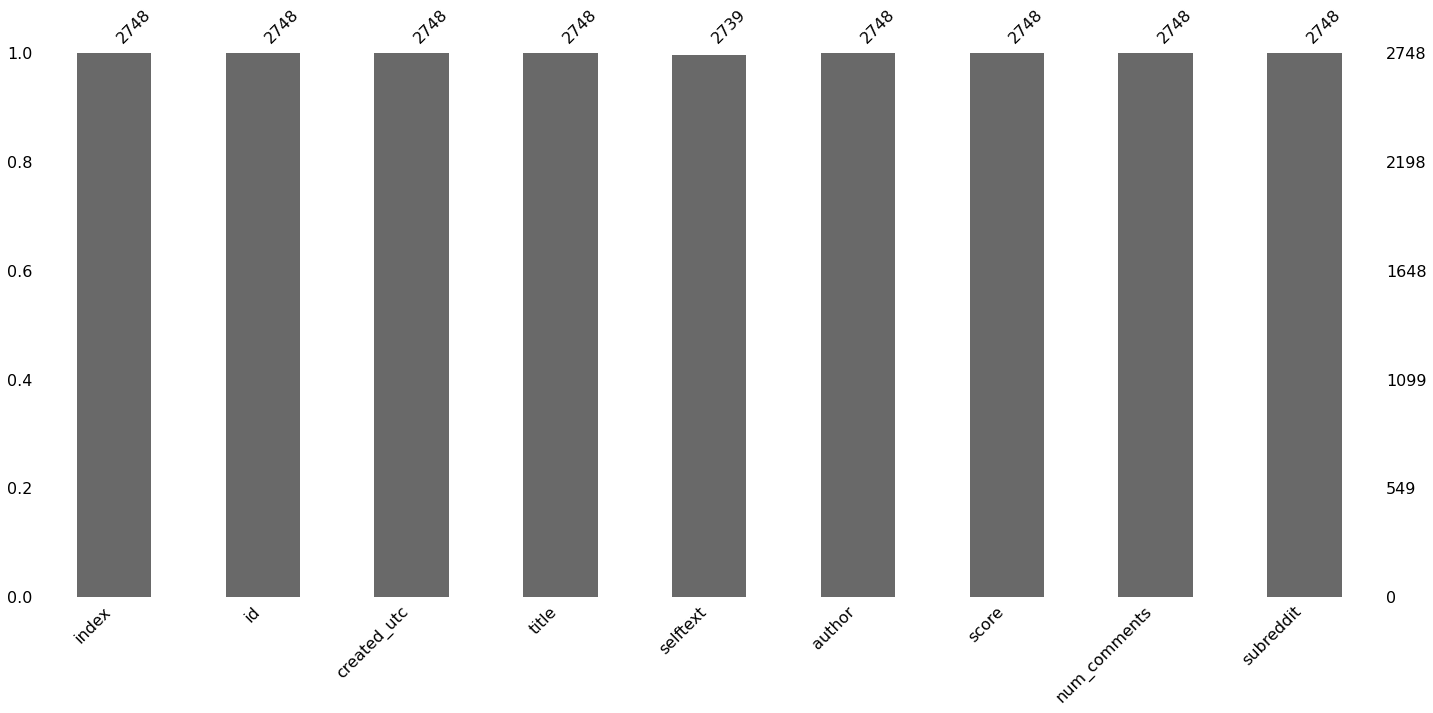

In [27]:
msno.bar(beer_1);

### Removing Null Values

In [28]:
beer_1 = beer_1.dropna()

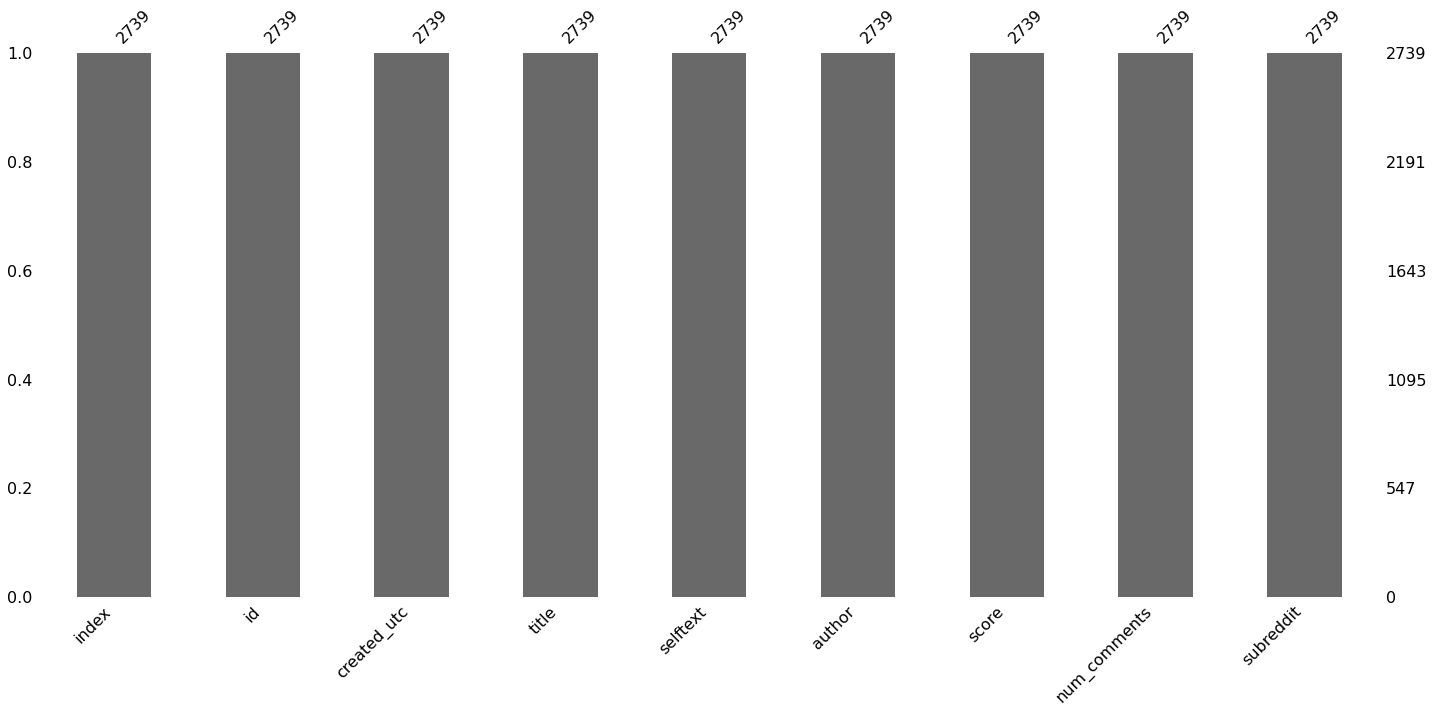

In [29]:
msno.bar(beer_1);

### Checking Value Counts
* [X] Looks like [removed] and [deleted] posts are taking up some of the values and reducing the percentage of unique values. 
* [X] There's a few other repeated values as well that need to be handle. The weekly Q&A is one. 

In [30]:
beer_1['selftext'].value_counts().nlargest(50)

### Eliminating all duplicates in 'selftext'
 * 219 weekly QA duplicates
 * 14 "this weekly thread.."
 * 8 "Have the next best recipe..."
 * 8 "You've had a week, what's..."
 * 8 "The once a week thread..."
 * 7 "Turbo cider, first batch..."
 * 3 "This is the monthly thread on last..."
 * and dozens of values with one duplicate. 

In [31]:
beer_1 = beer_1.drop_duplicates('selftext', keep = 'first').reset_index()

Checking duplicates. No more exist

In [32]:
beer_1['selftext'].value_counts().nlargest();

In [33]:
beer_1.nunique()

level_0         2378
index           2378
id              2378
created_utc     2378
title           2373
selftext        2378
author          1647
score             32
num_comments     111
subreddit          1
dtype: int64

### Checking Post Lengths
To ensure there is content in every post

In [34]:
for post in beer_1['selftext']:
    if len(post) < 10:
        print(post)

In [35]:
beer_1[beer_1['selftext'] == 'L']

,level_0,index,id,created_utc,title,selftext,author,score,num_comments,subreddit


Decided not to remove the above post because I am going to merge title and selftext together and it appears the title has some useful data. 

Creating a list of post lengths to add to a histogram

In [36]:
post_lengths = []
for post in beer_1['selftext']:
    post_lengths.append(len(post))
len(post_lengths) # ensuring I got all the values. 

2378

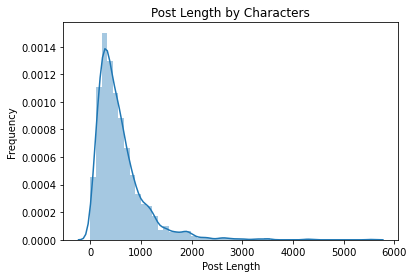

In [37]:
sns.distplot(post_lengths).set_title('Post Length by Characters')

plt.xlabel('Post Length')
plt.ylabel('Frequency');

______________________
# Step 4  
# Preliminary EDA
* This Exploratory Data Analysis is being conducted for the purpose of getting to know the data that surrounds the target data and predictor variables. It is also being utulized to identify any useful and interesting statistics or relationships that exist outside of predictive modeling and the exploratory process that preceeds modeling. 

### Unique Author / Unique Post Analysis

Unique Authors

In [38]:
unique_authors = beer_1['author'].nunique()
unique_authors

1647

Unique Posts

In [39]:
unique_posts = beer_1['selftext'].nunique()
unique_posts

2378

Authors of Multiple Posts
 
* There are 389 repeat authors of the 1612 unique authors.
* Almost 25% percent of authors are multiple posters. 
* As seen below that 25% accounts for almost half of all posts. 

In [40]:
author_multi = beer_1['author'].value_counts() > 1

In [41]:
author_multi.value_counts()

False    1272
True      375
Name: author, dtype: int64

In [42]:
389/ 1612

0.2413151364764268

In [43]:
total_multi_posts = beer_1['author'].value_counts().nlargest(389).sum()

In [44]:
total_multi_posts / unique_posts

0.47098402018502944

### Analyzing Posts with Multiple Comments

In [45]:
multi_comment_count = beer_1['num_comments'][beer_1['num_comments'] > 1].count()
multi_comment_count

2240

#### Boxplot for Number of Comments (Prior to Eliminating Outliers if Necessary)

Box plot showing distribution of the comment counts within and outside of the interquartile range. 

The whisker for the max quartile is the vertical grey line. It is the 75 percentile plus 1.5 times the interquartile range. The black dots past that whisker are considered outliers. There are quite a few outliers there. 

As detailed below, the vast majority of posts receiving multiple comments are located closer to zero than they are to one hundred. 

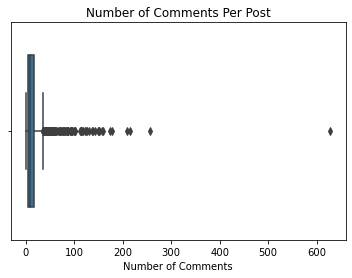

In [46]:
sns.boxplot(beer_1['num_comments'], width = .7, whis = 1.5).set_title('Number of Comments Per Post')

plt.xlabel('Number of Comments');

94 percent of posts had more than 1 comment. 

In [47]:
multi_comment_count / unique_posts

0.9419680403700589

In [48]:
beer_1.describe()

,level_0,index,created_utc,score,num_comments
count,2378.000000,2378.000000,2.378000e+03,2378.000000,2378.000000
mean,1370.091253,1510.687553,1.607465e+09,1.544575,14.778806
std,796.989125,865.238984,1.497032e+06,5.568927,23.131237
min,0.000000,0.000000,1.605019e+09,0.000000,0.000000
25%,671.250000,755.250000,1.606153e+09,1.000000,5.000000
50%,1379.500000,1523.500000,1.607393e+09,1.000000,9.000000
75%,2059.750000,2260.750000,1.608719e+09,1.000000,17.000000
max,2747.000000,2999.000000,1.610168e+09,198.000000,628.000000


If a post received less than 5 comments it was in the bottom 25% in terms of number of comments. If it received over 16 comments then it was in the upper 25% in terms of number of comments. 

### Analyzing Five Largest Comment Achievers

In [49]:
beer_1['num_comments'].nlargest()

963     628
408     257
2120    215
1158    209
314     177
Name: num_comments, dtype: int64

Checking to see if anything odd may be causing drastic comment numbers. 

In [50]:
beer_1.loc[[486, 1949, 1643, 681, 1626], 'selftext']

486     Howdy,\n\nAs the title states, I have just bee...
1949    I made this batch of apple and rasberry wine, ...
1643    I bought some mangrove jack kveik dry yeast ab...
681     I've got a kettle that already has welded TC f...
1626    Real talk. What color tilt hydrometer should I...
Name: selftext, dtype: object

The two Largest comment values seem to be an advertisement from a user named ink-bird. 
* [ ] Investigate ink-bird as an author. 
* [ ] Possibly delete all posts from ink-bird.

In [51]:
beer_1.loc[486, ['author', 'selftext']];

In [52]:
beer_1.loc[1949, ['author', 'selftext']];

In [53]:
beer_1.loc[1643, ['author', 'selftext']];

In [54]:
beer_1.loc[1643, 'selftext'];

In [55]:
beer_1.loc[681, ['author', 'selftext']];

In [56]:
beer_1.loc[681, 'selftext'];

In [57]:
beer_1.loc[1626, ['author','selftext']];

These were the only two posts from ink-bird. I am going to eliminate them because I feel the adds may not be representative of the spirit of the overall corpus. 

In [58]:
ink_bird = beer_1[beer_1['author'] == 'ink-bird']
ink_bird

,level_0,index,id,created_utc,title,selftext,author,score,num_comments,subreddit
963,1118,1243,kcboe5,1607870448,🎁🎄Christmas Giveaway for Inkbird Waterproof In...,🎁Inkbird would like to give away **TWO FREE** ...,ink-bird,1,628,Homebrewing


Eliminating posts from author 'ink-bird'

In [59]:
beer_1 = beer_1[beer_1['author'] != 'ink-bird']

Checking to ensure they have been removed

In [60]:
ink_bird = beer_1[beer_1['author'] == 'ink-bird']
ink_bird

,level_0,index,id,created_utc,title,selftext,author,score,num_comments,subreddit


#### Boxplot for Multiple Posts (After Eliminating a Few Outliers)

The boxplot is a bit more clear to understand but the overall trends remain the same. 

Most values are located closer to zero and almost all values have recieved less than 25 comments. There are still quite a few outliers but after inspect they all appear to be legitimate. 

One day I may come back and investigate what makes some of these posts so successful in regards to receiving comments. 

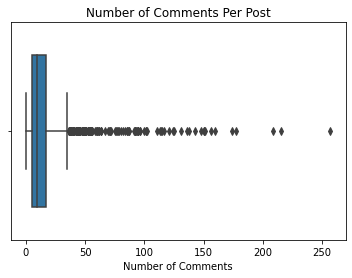

In [61]:
sns.boxplot(beer_1['num_comments'], width = .7, whis = 1.5).set_title('Number of Comments Per Post')

plt.xlabel('Number of Comments');

### Analyzing Score

In [62]:
beer_1['score'].nlargest()

2080    198
2103    108
2099     81
2168     50
2120     49
Name: score, dtype: int64

Posts that scored over 1 (the base score) accounted for just over 7 percent. 

In [63]:
score_over_1_count = beer_1['score'][beer_1['score'] > 1].count()
score_over_1_count

180

In [64]:
score_over_1_count / unique_posts

0.07569386038687972

Analyzing the top 5 for score

In [65]:
beer_1.loc[1603, 'selftext'];

In [66]:
beer_1.loc[1626, 'selftext'];

In [67]:
beer_1.loc[1622, 'selftext'];

In [68]:
beer_1.loc[1691, 'selftext'];

In [69]:
beer_1.loc[1643, 'selftext'];

# Step 5 
# Preparing DF for Text Analysis

In [70]:
beer_1 = beer_1.drop(columns = ['level_0', 'index', 'id', 'created_utc', 'author', 'score', 'num_comments'])

In [71]:
beer_1.columns

Index(['title', 'selftext', 'subreddit'], dtype='object')

### Adding title to self text for the purpose of text analysis. 

In [72]:
beer_1['selftext'] = beer_1['title'] + ' ' + beer_1['selftext']

In [73]:
beer_1['selftext'].head()

0    Getting to the bottom of my keg and it is yeas...
1    Pressure fermentation but bottling.. a never b...
2    Experimental DME barley wine I have some older...
3    Priming solution question This is my second ex...
4    What is the name of this simple mixed drink I'...
Name: selftext, dtype: object

In [74]:
beer_1.drop(columns = ['title'], inplace = True)

# Saving new df to CSV

In [75]:
beer_1.to_csv('../data/01_beer.csv', index = False)